# Train Interspeech

## Data

In [1]:
balanced = False

In [2]:
import pandas as pd

# Cargar el CSV para male
data = pd.read_csv('data/balanced_pseudo_female.csv')
print(len(data))
# Eliminar filas con valores nulos solo en la columna 'text'
data = data.dropna(subset=['text'])
#data.to_csv('data/data_female.csv', index=False)
print(len(data))
data.head()

4960
4960


,FileName,text,EmoClass,EmoAct,EmoVal,EmoDom,SpkrID,Gender,Split_Set,PodcastID,StratifyCol,NewPartition,PseudoEmo,InvEntropyNorm,PseudoEmoNum
0,MSP-PODCAST_4510_0076_0002,...is a beautiful child. so how can you just b...,A,4.8,3.6,4.8,1945,Female,Development,4510,4510_1945_A,Test,A,1.000000,2
1,MSP-PODCAST_2422_0692,if he's not following the same playbook. of-co...,X,6.0,1.6,6.6,210,Female,Development,2422,2422_210_X,Train,A,0.564979,2
2,MSP-PODCAST_4722_0241,sometimes i'll like look for everyone and be l...,A,3.4,2.2,3.8,2585,Female,Development,4722,4722_2585_A,Test,A,1.000000,2
3,MSP-PODCAST_4759_0744,what do we need a bunch of horny women running...,A,3.8,3.0,4.2,2603,Female,Development,4759,4759_2603_A,Test,A,1.000000,2
4,MSP-PODCAST_5494_1418,"families and just our business, our travels-",A,5.4,3.2,4.2,263,Female,Train,5494,5494_263_A,Train,A,1.000000,2


In [3]:
if balanced:
    # Paso 1: Determinar el tamaño mínimo entre las clases
    min_count = data['PseudoEmo'].value_counts().min()

    # Paso 2: Submuestrear cada clase
    data = data.groupby('PseudoEmo').apply(lambda x: x.sample(min_count)).reset_index(drop=True)

    # Paso 3: Verificar el balance
    print(data['PseudoEmo'].value_counts())
    print(len(data))

    data.to_csv('data/balanced_pseudo_female.csv', index=False)


In [4]:
# Filtrar los datos en tres conjuntos basados en la columna 'Split_Set'
train_df = data.loc[data['NewPartition'] == 'Train']
dev_df = data.loc[data['NewPartition'] == 'Evaluation']
test_df = data.loc[data['NewPartition'] == 'Test']

# Verifica las primeras filas de cada conjunto
print("Conjunto Train:")
print(train_df.head())

print("Conjunto Development:")
print(dev_df.head())

print("Conjunto Test:")
print(test_df.head())

Conjunto Train:
                      FileName  \
1        MSP-PODCAST_2422_0692   
4        MSP-PODCAST_5494_1418   
6        MSP-PODCAST_2408_0073   
7   MSP-PODCAST_0860_0242_0004   
11       MSP-PODCAST_0939_0139   

                                                 text EmoClass    EmoAct  \
1   if he's not following the same playbook. of-co...        X  6.000000   
4        families and just our business, our travels-        A  5.400000   
6    and they can match it and they can say, "oh, ...        A  6.400000   
7    that example because it, in many ways it offe...        X  5.363636   
11   00:01:48].it bothers me because it reminds me...        A  4.400000   

      EmoVal    EmoDom  SpkrID  Gender    Split_Set  PodcastID  StratifyCol  \
1   1.600000  6.600000     210  Female  Development       2422   2422_210_X   
4   3.200000  4.200000     263  Female        Train       5494   5494_263_A   
6   1.400000  6.600000    1391  Female        Train       2408  2408_1391_A   
7   2.

In [5]:
# # Establecer la semilla para garantizar reproducibilidad
# seed = 42

# # Seleccionar aleatoriamente las primeras N filas del conjunto de entrenamiento
# train_df = train_df.sample(n=1000, random_state=seed)

# # Seleccionar aleatoriamente las primeras N filas del conjunto de desarrollo
# dev_df = dev_df.sample(n=250, random_state=seed)

In [6]:
num_labels = 8
id2label = dict(zip(train_df["PseudoEmoNum"], train_df["PseudoEmo"]))
label2id = dict(zip(train_df["PseudoEmo"], train_df["PseudoEmoNum"]))

In [7]:
# Convertir EmoClass a valores numéricos si es necesario
train_df['PseudoEmoNum'] = train_df['PseudoEmoNum'].astype(int)
dev_df['PseudoEmoNum'] = dev_df['PseudoEmoNum'].astype(int)
test_df['PseudoEmoNum'] = test_df['PseudoEmoNum'].astype(int)

/var/folders/dh/_ks73kfn57l67vxm7b5y16qw0000gn/T/ipykernel_22802/2335822977.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['PseudoEmoNum'] = train_df['PseudoEmoNum'].astype(int)
/var/folders/dh/_ks73kfn57l67vxm7b5y16qw0000gn/T/ipykernel_22802/2335822977.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dev_df['PseudoEmoNum'] = dev_df['PseudoEmoNum'].astype(int)
/var/folders/dh/_ks73kfn57l67vxm7b5y16qw0000gn/T/ipykernel_22802/2335822977.py:4: SettingWithCopyWarning: 
A value is trying to be s

In [8]:
from datasets import Dataset
from transformers import AutoTokenizer

# Modelo
model_ckpt = "distilbert-base-uncased"

# Cargar el tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

# Función para tokenizar los datos
def tokenize_function(examples):
    # Verificar que estamos pasando una lista de textos
    texts = examples['text']
    return tokenizer(texts, padding="max_length", truncation=True)

# Asegurarse de que 'train_df' y 'dev_df' son objetos Dataset de Hugging Face
train_dataset = Dataset.from_pandas(train_df)
dev_dataset = Dataset.from_pandas(dev_df)
test_dataset = Dataset.from_pandas(test_df)


# Tokenizamos ambos conjuntos de datos
train_dataset = train_dataset.map(tokenize_function, batched=True)
dev_dataset = dev_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)


# Renombrar columna de labels
train_dataset = train_dataset.rename_column("PseudoEmoNum", "labels")
dev_dataset = dev_dataset.rename_column("PseudoEmoNum", "labels")
test_dataset = test_dataset.rename_column("PseudoEmoNum", "labels")


/Users/jorgegarcelan/Desktop/UNI/6-LAB TSC/interspeech-nlp/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jorgegarcelan/Desktop/UNI/6-LAB TSC/interspeech-nlp/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Map: 100%|██████████| 1599/1599 [00:00<00:00, 13146.43 examples/s]


## Code

In [9]:
from transformers import AutoTokenizer
import torch
print(torch.__version__)  # Esto debería mostrarte la versión de PyTorch instalada

2.5.1


In [10]:
from transformers import AutoModelForSequenceClassification
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device)
print(model.num_labels)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


8


In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    # Obtener reporte completo
    report = classification_report(labels, predictions, output_dict=True)
    
    # Obtener la matriz de confusión
    conf_matrix = confusion_matrix(labels, predictions)
    
    # Extraer métricas para cada clase y globales
    metrics = {
        'accuracy': report['accuracy'],
        'macro_f1': report['macro avg']['f1-score'],
        'weighted_f1': report['weighted avg']['f1-score'],
        # 'weighted_precision': report['weighted avg']['precision'],
        # 'weighted_recall': report['weighted avg']['recall'],
        'confusion_matrix': conf_matrix.tolist()  # Convertir a lista para asegurarse de que es serializable si es necesario
    }
    
    # # Añadir métricas específicas por clase si se requiere
    # for label, scores in report.items():
    #     if label not in ["accuracy", "macro avg", "weighted avg"]:
    #         metrics[f'{label}_precision'] = scores['precision']
    #         metrics[f'{label}_recall'] = scores['recall']
    #         metrics[f'{label}_f1'] = scores['f1-score']
    #         metrics[f'{label}_support'] = scores['support']
    
    return metrics

In [12]:
from transformers import Trainer, TrainingArguments

batch_size = 32
logging_steps = len(train_dataset) // batch_size
model_name = f"{model_ckpt}-finetuned-female"
training_args = TrainingArguments(
    output_dir=model_name,
    num_train_epochs=10,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps,
    #push_to_hub=True,
    log_level="error"
)

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
    tokenizer=tokenizer
)

/Users/jorgegarcelan/Desktop/UNI/6-LAB TSC/interspeech-nlp/.venv/lib/python3.9/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/var/folders/dh/_ks73kfn57l67vxm7b5y16qw0000gn/T/ipykernel_22802/1159178048.py:20: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [13]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1,Confusion Matrix
1,2.046700,1.988698,0.257951,0.145131,0.171735,"[[64, 11, 53, 5, 0, 0, 0, 0], [43, 36, 39, 0, 0, 0, 0, 0], [16, 5, 111, 2, 0, 0, 0, 0], [35, 7, 52, 8, 0, 0, 0, 0], [16, 4, 54, 2, 0, 0, 0, 0], [37, 11, 46, 3, 0, 0, 0, 0], [15, 4, 61, 4, 0, 0, 0, 0], [33, 13, 55, 4, 0, 0, 0, 0]]"
2,1.915800,1.939863,0.276796,0.168927,0.196171,"[[51, 14, 43, 25, 0, 0, 0, 0], [29, 40, 28, 21, 0, 0, 0, 0], [11, 5, 110, 8, 0, 0, 0, 0], [22, 9, 37, 34, 0, 0, 0, 0], [13, 7, 46, 10, 0, 0, 0, 0], [30, 14, 36, 17, 0, 0, 0, 0], [5, 5, 57, 17, 0, 0, 0, 0], [26, 13, 45, 21, 0, 0, 0, 0]]"
3,1.771300,1.914397,0.290931,0.183739,0.212618,"[[65, 13, 34, 19, 1, 0, 0, 1], [31, 47, 20, 19, 0, 1, 0, 0], [16, 9, 98, 10, 1, 0, 0, 0], [26, 11, 28, 36, 0, 0, 0, 1], [16, 6, 45, 9, 0, 0, 0, 0], [42, 16, 23, 15, 0, 1, 0, 0], [12, 7, 46, 16, 3, 0, 0, 0], [30, 15, 33, 26, 1, 0, 0, 0]]"
4,1.618500,1.953519,0.288575,0.206503,0.230655,"[[63, 14, 22, 23, 3, 0, 6, 2], [30, 49, 17, 18, 3, 0, 1, 0], [18, 8, 86, 13, 7, 0, 2, 0], [24, 12, 19, 36, 4, 0, 6, 1], [12, 8, 35, 10, 4, 1, 5, 1], [40, 19, 20, 15, 1, 0, 1, 1], [15, 5, 38, 15, 4, 0, 6, 1], [28, 14, 23, 29, 3, 0, 7, 1]]"
5,1.476100,1.985464,0.281508,0.204479,0.229648,"[[64, 11, 18, 26, 6, 0, 2, 6], [30, 45, 17, 18, 3, 1, 0, 4], [18, 8, 81, 18, 6, 0, 2, 1], [25, 9, 15, 40, 5, 0, 4, 4], [14, 4, 33, 15, 5, 2, 1, 2], [44, 10, 19, 16, 3, 0, 0, 5], [16, 5, 30, 16, 8, 0, 3, 6], [31, 9, 20, 30, 12, 1, 1, 1]]"
6,1.355500,2.037487,0.281508,0.220276,0.242147,"[[51, 14, 15, 36, 7, 0, 3, 7], [22, 49, 14, 23, 3, 1, 1, 5], [10, 13, 75, 21, 8, 0, 4, 3], [20, 11, 11, 45, 5, 1, 5, 4], [8, 7, 30, 17, 7, 2, 1, 4], [27, 20, 18, 21, 3, 3, 0, 5], [12, 5, 30, 18, 6, 1, 5, 7], [20, 17, 16, 36, 9, 1, 2, 4]]"
7,1.234900,2.068330,0.287397,0.244680,0.265089,"[[53, 12, 13, 29, 11, 2, 4, 9], [22, 50, 11, 20, 5, 1, 2, 7], [10, 11, 65, 18, 14, 0, 2, 14], [21, 10, 9, 43, 8, 2, 6, 3], [8, 6, 26, 14, 9, 5, 3, 5], [27, 15, 17, 14, 4, 10, 1, 9], [12, 5, 24, 15, 12, 2, 5, 9], [20, 14, 13, 34, 9, 4, 2, 9]]"
8,1.131800,2.110256,0.280330,0.240363,0.260147,"[[52, 13, 14, 25, 10, 1, 4, 14], [26, 50, 10, 15, 4, 1, 4, 8], [11, 14, 64, 13, 15, 0, 4, 13], [21, 10, 10, 37, 7, 1, 7, 9], [9, 5, 24, 12, 10, 4, 6, 6], [24, 16, 17, 11, 6, 8, 2, 13], [12, 5, 24, 15, 12, 2, 5, 9], [22, 16, 15, 25, 11, 2, 2, 12]]"
9,1.076000,2.136431,0.277974,0.242380,0.261538,"[[57, 14, 10, 23, 8, 2, 4, 15], [29, 52, 5, 12, 4, 2, 2, 12], [12, 14, 53, 13, 13, 1, 5, 23], [24, 10, 7, 36, 10, 2, 5, 8], [13, 6, 20, 14, 10, 4, 4, 5], [27, 17, 12, 13, 7, 11, 2, 8], [14, 5, 21, 16, 12, 3, 4, 9], [28, 13, 12, 26, 8, 3, 2, 13]]"
10,1.031500,2.150240,0.273263,0.237134,0.256716,"[[54, 14, 11, 25, 9, 1, 4, 15], [27, 49, 6, 14, 3, 1, 3, 15], [11, 13, 55, 17, 11, 0, 5, 22], [22, 10, 7, 37, 9, 2, 6, 9], [12, 6, 21, 15, 9, 4, 4, 5], [27, 17, 13, 14, 5, 9, 2, 10], [12, 5, 21, 17, 12, 2, 4, 11], [26, 12, 12, 27, 8, 3, 2, 15]]"


/Users/jorgegarcelan/Desktop/UNI/6-LAB TSC/interspeech-nlp/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jorgegarcelan/Desktop/UNI/6-LAB TSC/interspeech-nlp/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jorgegarcelan/Desktop/UNI/6-LAB TSC/interspeech-nlp/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division`

TrainOutput(global_step=790, training_loss=1.4607400314717354, metrics={'train_runtime': 3265.7746, 'train_samples_per_second': 7.692, 'train_steps_per_second': 0.242, 'total_flos': 3327937110343680.0, 'train_loss': 1.4607400314717354, 'epoch': 10.0})

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Weighted F1,Confusion Matrix
1,2.046700,1.988698,0.257951,0.145131,0.171735,"[[64, 11, 53, 5, 0, 0, 0, 0], [43, 36, 39, 0, 0, 0, 0, 0], [16, 5, 111, 2, 0, 0, 0, 0], [35, 7, 52, 8, 0, 0, 0, 0], [16, 4, 54, 2, 0, 0, 0, 0], [37, 11, 46, 3, 0, 0, 0, 0], [15, 4, 61, 4, 0, 0, 0, 0], [33, 13, 55, 4, 0, 0, 0, 0]]"
2,1.915800,1.939863,0.276796,0.168927,0.196171,"[[51, 14, 43, 25, 0, 0, 0, 0], [29, 40, 28, 21, 0, 0, 0, 0], [11, 5, 110, 8, 0, 0, 0, 0], [22, 9, 37, 34, 0, 0, 0, 0], [13, 7, 46, 10, 0, 0, 0, 0], [30, 14, 36, 17, 0, 0, 0, 0], [5, 5, 57, 17, 0, 0, 0, 0], [26, 13, 45, 21, 0, 0, 0, 0]]"
3,1.771300,1.914397,0.290931,0.183739,0.212618,"[[65, 13, 34, 19, 1, 0, 0, 1], [31, 47, 20, 19, 0, 1, 0, 0], [16, 9, 98, 10, 1, 0, 0, 0], [26, 11, 28, 36, 0, 0, 0, 1], [16, 6, 45, 9, 0, 0, 0, 0], [42, 16, 23, 15, 0, 1, 0, 0], [12, 7, 46, 16, 3, 0, 0, 0], [30, 15, 33, 26, 1, 0, 0, 0]]"
4,1.618500,1.953519,0.288575,0.206503,0.230655,"[[63, 14, 22, 23, 3, 0, 6, 2], [30, 49, 17, 18, 3, 0, 1, 0], [18, 8, 86, 13, 7, 0, 2, 0], [24, 12, 19, 36, 4, 0, 6, 1], [12, 8, 35, 10, 4, 1, 5, 1], [40, 19, 20, 15, 1, 0, 1, 1], [15, 5, 38, 15, 4, 0, 6, 1], [28, 14, 23, 29, 3, 0, 7, 1]]"
5,1.476100,1.985464,0.281508,0.204479,0.229648,"[[64, 11, 18, 26, 6, 0, 2, 6], [30, 45, 17, 18, 3, 1, 0, 4], [18, 8, 81, 18, 6, 0, 2, 1], [25, 9, 15, 40, 5, 0, 4, 4], [14, 4, 33, 15, 5, 2, 1, 2], [44, 10, 19, 16, 3, 0, 0, 5], [16, 5, 30, 16, 8, 0, 3, 6], [31, 9, 20, 30, 12, 1, 1, 1]]"
6,1.355500,2.037487,0.281508,0.220276,0.242147,"[[51, 14, 15, 36, 7, 0, 3, 7], [22, 49, 14, 23, 3, 1, 1, 5], [10, 13, 75, 21, 8, 0, 4, 3], [20, 11, 11, 45, 5, 1, 5, 4], [8, 7, 30, 17, 7, 2, 1, 4], [27, 20, 18, 21, 3, 3, 0, 5], [12, 5, 30, 18, 6, 1, 5, 7], [20, 17, 16, 36, 9, 1, 2, 4]]"
7,1.234900,2.068330,0.287397,0.244680,0.265089,"[[53, 12, 13, 29, 11, 2, 4, 9], [22, 50, 11, 20, 5, 1, 2, 7], [10, 11, 65, 18, 14, 0, 2, 14], [21, 10, 9, 43, 8, 2, 6, 3], [8, 6, 26, 14, 9, 5, 3, 5], [27, 15, 17, 14, 4, 10, 1, 9], [12, 5, 24, 15, 12, 2, 5, 9], [20, 14, 13, 34, 9, 4, 2, 9]]"
8,1.131800,2.110256,0.280330,0.240363,0.260147,"[[52, 13, 14, 25, 10, 1, 4, 14], [26, 50, 10, 15, 4, 1, 4, 8], [11, 14, 64, 13, 15, 0, 4, 13], [21, 10, 10, 37, 7, 1, 7, 9], [9, 5, 24, 12, 10, 4, 6, 6], [24, 16, 17, 11, 6, 8, 2, 13], [12, 5, 24, 15, 12, 2, 5, 9], [22, 16, 15, 25, 11, 2, 2, 12]]"
9,1.076000,2.136431,0.277974,0.242380,0.261538,"[[57, 14, 10, 23, 8, 2, 4, 15], [29, 52, 5, 12, 4, 2, 2, 12], [12, 14, 53, 13, 13, 1, 5, 23], [24, 10, 7, 36, 10, 2, 5, 8], [13, 6, 20, 14, 10, 4, 4, 5], [27, 17, 12, 13, 7, 11, 2, 8], [14, 5, 21, 16, 12, 3, 4, 9], [28, 13, 12, 26, 8, 3, 2, 13]]"
10,1.031500,2.150240,0.273263,0.237134,0.256716,"[[54, 14, 11, 25, 9, 1, 4, 15], [27, 49, 6, 14, 3, 1, 3, 15], [11, 13, 55, 17, 11, 0, 5, 22], [22, 10, 7, 37, 9, 2, 6, 9], [12, 6, 21, 15, 9, 4, 4, 5], [27, 17, 13, 14, 5, 9, 2, 10], [12, 5, 21, 17, 12, 2, 4, 11], [26, 12, 12, 27, 8, 3, 2, 15]]"


/Users/jorgegarcelan/Desktop/UNI/6-LAB TSC/interspeech-nlp/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jorgegarcelan/Desktop/UNI/6-LAB TSC/interspeech-nlp/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/jorgegarcelan/Desktop/UNI/6-LAB TSC/interspeech-nlp/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division`

TrainOutput(global_step=790, training_loss=1.4607400314717354, metrics={'train_runtime': 3265.7746, 'train_samples_per_second': 7.692, 'train_steps_per_second': 0.242, 'total_flos': 3327937110343680.0, 'train_loss': 1.4607400314717354, 'epoch': 10.0})

In [14]:
preds_output = trainer.predict(test_dataset)
preds_metrics = preds_output.metrics
preds_metrics

{'test_loss': 2.310947895050049,
 'test_accuracy': 0.18699186991869918,
 'test_macro_f1': 0.1796368602523784,
 'test_weighted_f1': 0.1669316429531844,
 'test_confusion_matrix': [[25, 16, 7, 16, 6, 1, 1, 4],
  [23, 55, 10, 9, 2, 5, 2, 6],
  [13, 10, 42, 28, 15, 5, 8, 22],
  [36, 13, 26, 76, 11, 4, 13, 24],
  [37, 42, 50, 45, 29, 9, 23, 36],
  [55, 71, 28, 48, 14, 10, 5, 31],
  [34, 35, 57, 69, 24, 7, 31, 39],
  [42, 22, 28, 74, 15, 7, 17, 31]],
 'test_runtime': 49.4058,
 'test_samples_per_second': 32.365,
 'test_steps_per_second': 1.012}

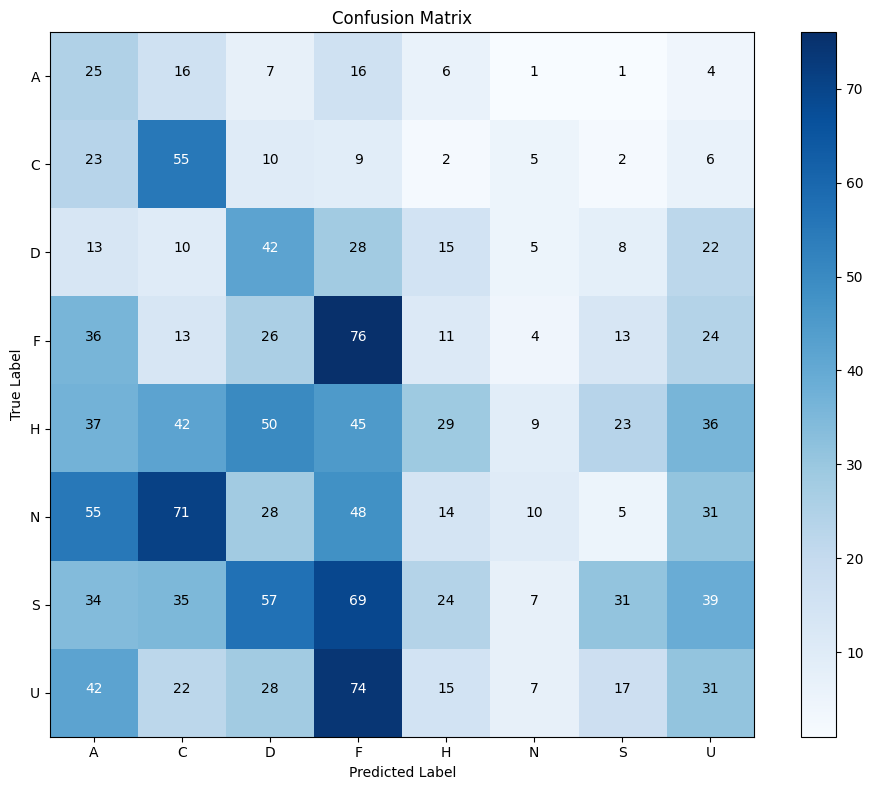

In [15]:
import matplotlib.pyplot as plt
import numpy as np

labels = label2id.keys()
conf_matrix = preds_metrics['test_confusion_matrix']

# Crear el gráfico de la matriz de confusión
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()

# Agregar etiquetas
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels)
plt.yticks(tick_marks, labels)

# Rótulos de valores dentro de cada celda
conf_matrix = np.array(conf_matrix)

# Calcular el umbral
thresh = conf_matrix.max() / 2
for i, j in np.ndindex(conf_matrix.shape):
    plt.text(
        j, i, format(conf_matrix[i, j], 'd'),
        horizontalalignment="center",
        color="white" if conf_matrix[i, j] > thresh else "black"
    )

# Etiquetas de los ejes
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()